In [1]:
import pandas as pd
import numpy as np
import json
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

from matplotlib import font_manager, rc

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [3]:
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL);

In [5]:
smp_da_data = pd.read_csv('../data/제주전력시장_시장전기가격_하루전가격.csv')
smp_rc_data = pd.read_csv('../data/제주전력시장_시장전기가격_실시간가격.csv')
supply_data = pd.read_csv('../data/제주전력시장_현황데이터.csv')
weather_rdata1 = pd.read_csv('../data/기상실측데이터_1.csv')
weather_rdata2 = pd.read_csv('../data/기상실측데이터_2.csv')
weather_fdata1 = pd.read_csv('../data/기상예측데이터_1.csv')
weather_fdata2 = pd.read_csv('../data/기상예측데이터_2.csv')

In [7]:
display_df(smp_da_data, 'day ahead')
display_df(smp_rc_data, 'real')
display_df(supply_data, 'supply')
display_df(weather_rdata1, 'real weather 1')
display_df(weather_rdata2, 'real weather 2')
display_df(weather_fdata1, 'weather forecast 1')
display_df(weather_fdata2, 'weather forecast 2')

day ahead data has 6217 rows and 2 columns. 
 ===> First row:


ts  smp_da
0  1709218800  107.39

real data has 24575 rows and 3 columns. 
 ===> First row:


ts  smp_rt  smp_rc
0  1709218800    95.3    95.3

supply data has 90560 rows and 8 columns. 
 ===> First row:


ts  supply_power  present_load  power_solar  power_wind  \
0  1704034800     1298000.0      769000.0          0.0    125426.0   

   renewable_energy_total  supply_capacity  operation_capacity  
0                133103.0         529000.0            323000.0

real weather 1 data has 70645 rows and 19 columns. 
 ===> First row:


location          ts  temp  real_feel_temp  real_feel_temp_shade  rel_hum  \
0  Ilgwa-ri  1709222220   6.9             2.4                   2.4     69.0   

   dew_point  wind_dir  wind_spd  wind_gust_spd  uv_idx   vis  cld_cvr  \
0        1.5     338.0      18.7           37.7     0.0  17.7     98.0   

   ceiling  pressure  appr_temp  wind_chill_temp  wet_bulb_temp  precip_1h  
0    579.0    1022.0        8.3              3.3            4.5        0.0

real weather 2 data has 37244 rows and 12 columns. 
 ===> First row:


location          ts  cloud  temp  temp_max  temp_min  humidity  \
0  Gaigeturi  1709218856   80.0  8.03      8.03      8.03      73.0   

   ground_press  wind_speed  wind_dir  rain  snow  
0        1023.0       10.34     352.0   0.0   0.0

weather forecast 1 data has 58500 rows and 23 columns. 
 ===> First row:


location     base_ts          ts     temp  real_feel_temp  wet_bulb_temp  \
0  Ilgwa-ri  1709258400  1709305200  3.33333        -3.88889        1.11111   

   dew_point  wind_dir  wind_spd  wind_gust_spd  ...  uv_idx  precip_prob  \
0   -2.77778     343.0   27.8417        59.2239  ...     0.0          0.0   

   rain_prob  snow_prob  ice_prob  total_liq  rain  snow  ice  cld_cvr  
0        0.0        0.0       0.0        0.0   0.0   0.0  0.0     81.0  

[1 rows x 23 columns]

weather forecast 2 data has 19500 rows and 13 columns. 
 ===> First row:


location     base_ts          ts  cloud  temp  temp_max  temp_min  \
0  Gaigeturi  1709258400  1709305200  100.0  3.23      3.23      3.23   

   humidity  ground_press  wind_speed  wind_dir  rain  snow  
0      59.0        1027.0        9.59     337.0   0.0   0.0

In [9]:
merged_data = smp_da_data.merge(supply_data, on='ts', how='left')

In [11]:
merged_data['supply_demand_diff'] = merged_data['supply_power'] - merged_data['present_load']
merged_data.head()

ts  smp_da  supply_power  present_load  power_solar  power_wind  \
0  1709218800  107.39     1388000.0      798000.0          0.0    234165.0   
1  1709222400  107.39     1367000.0      765000.0          0.0    210320.0   
2  1709226000   95.30     1403000.0      736000.0          0.0    245230.0   
3  1709229600   87.89     1376000.0      727000.0          0.0    225240.0   
4  1709233200    0.00     1362000.0      741000.0          0.0    209575.0   

   renewable_energy_total  supply_capacity  operation_capacity  \
0                248660.0         590000.0            266000.0   
1                226351.0         602000.0            277000.0   
2                261327.0         666000.0            342000.0   
3                239324.0         649000.0            323000.0   
4                223575.0         621000.0            297000.0   

   supply_demand_diff  
0            590000.0  
1            602000.0  
2            667000.0  
3            649000.0  
4            621000.0

In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217 entries, 0 to 6216
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ts                      6217 non-null   int64  
 1   smp_da                  6217 non-null   float64
 2   supply_power            6203 non-null   float64
 3   present_load            6203 non-null   float64
 4   power_solar             6203 non-null   float64
 5   power_wind              6203 non-null   float64
 6   renewable_energy_total  6160 non-null   float64
 7   supply_capacity         6160 non-null   float64
 8   operation_capacity      6160 non-null   float64
 9   supply_demand_diff      6203 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 485.8 KB


In [15]:
print(weather_fdata1['location'].nunique())
print(weather_fdata1['location'].unique())

9
['Ilgwa-ri' 'Geumak-ri' 'Yongsu-ri' 'Hacheon-ri' 'Cheonji-dong'
 'Songdang-ri' 'Bonggae-dong' 'Gwangryeong-ri' 'Sangmo-ri']


Index(['temp', 'real_feel_temp', 'wet_bulb_temp', 'dew_point', 'wind_dir',
       'wind_spd', 'wind_gust_spd', 'rel_hum', 'vis', 'ceiling', 'uv_idx',
       'precip_prob', 'rain_prob', 'snow_prob', 'ice_prob', 'total_liq',
       'rain', 'snow', 'ice', 'cld_cvr'],
      dtype='object')
temp


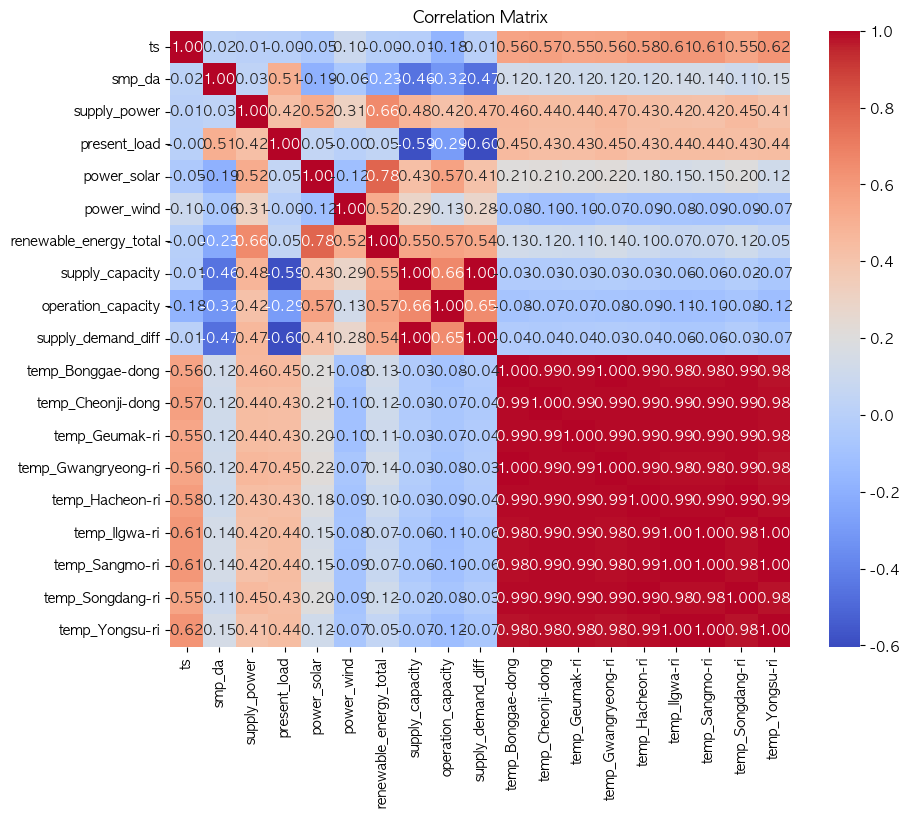

real_feel_temp


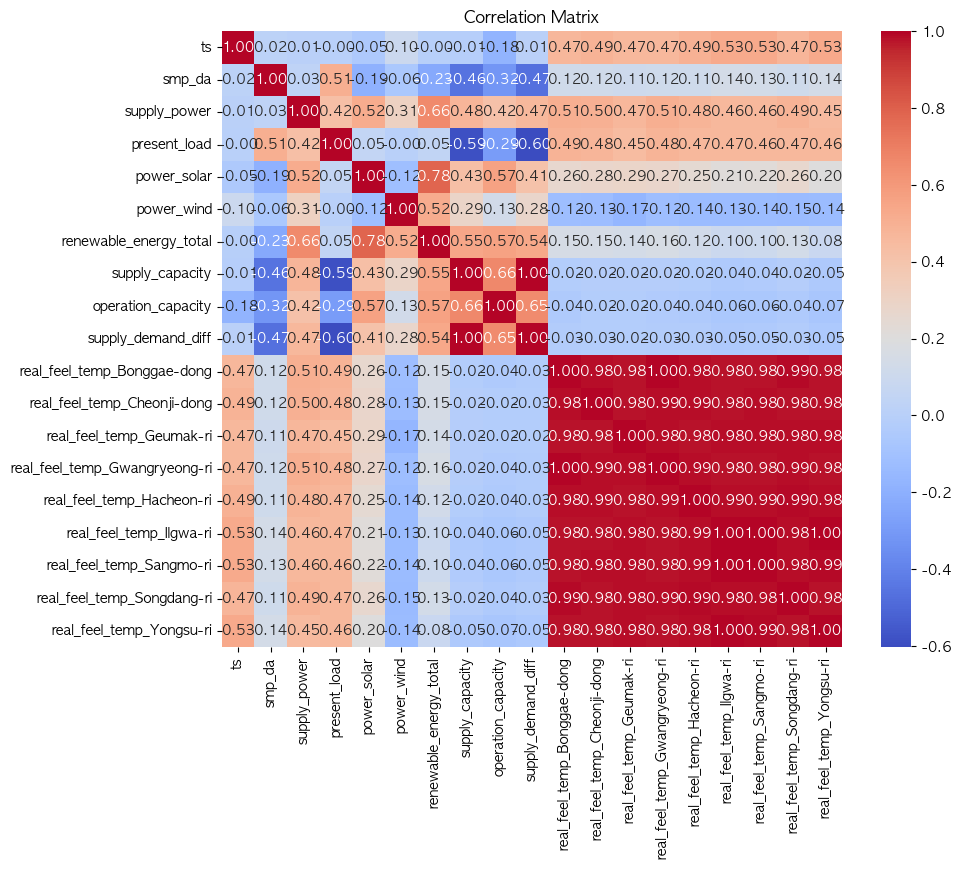

wet_bulb_temp


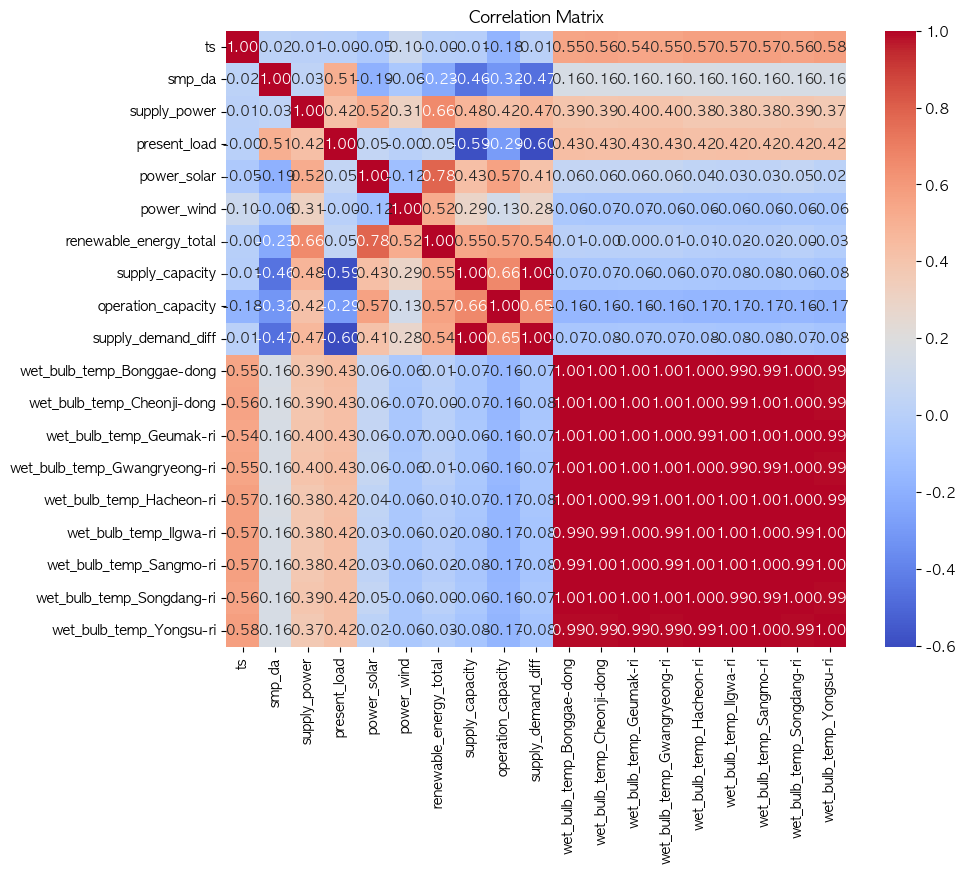

dew_point


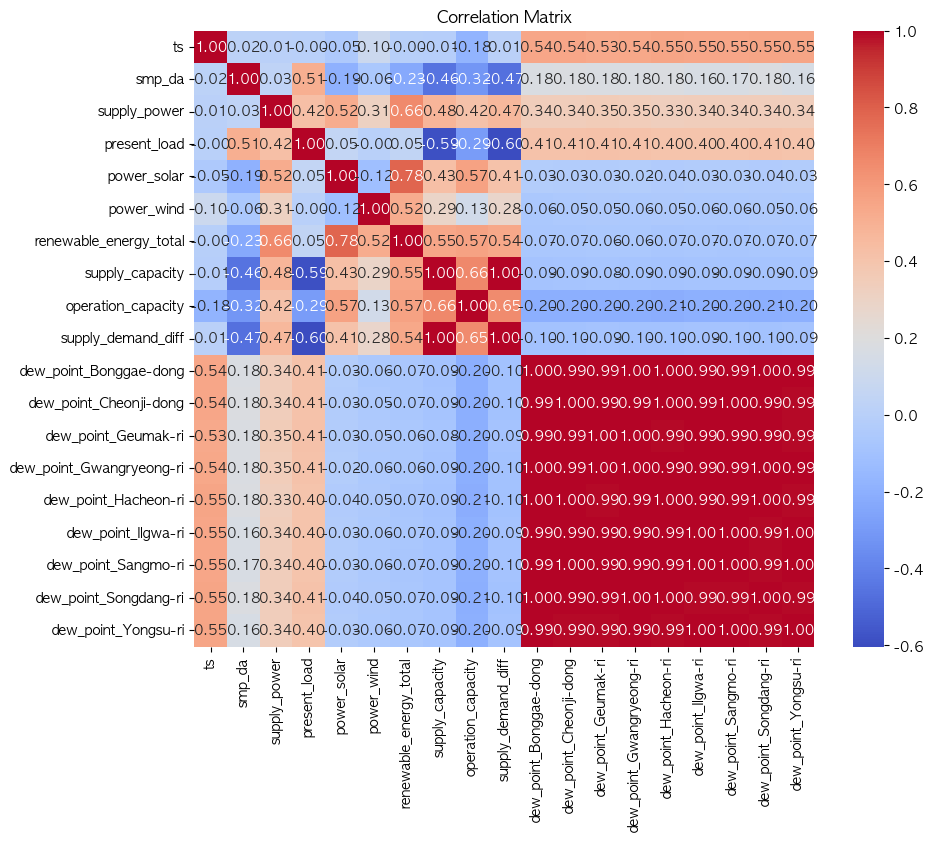

wind_dir


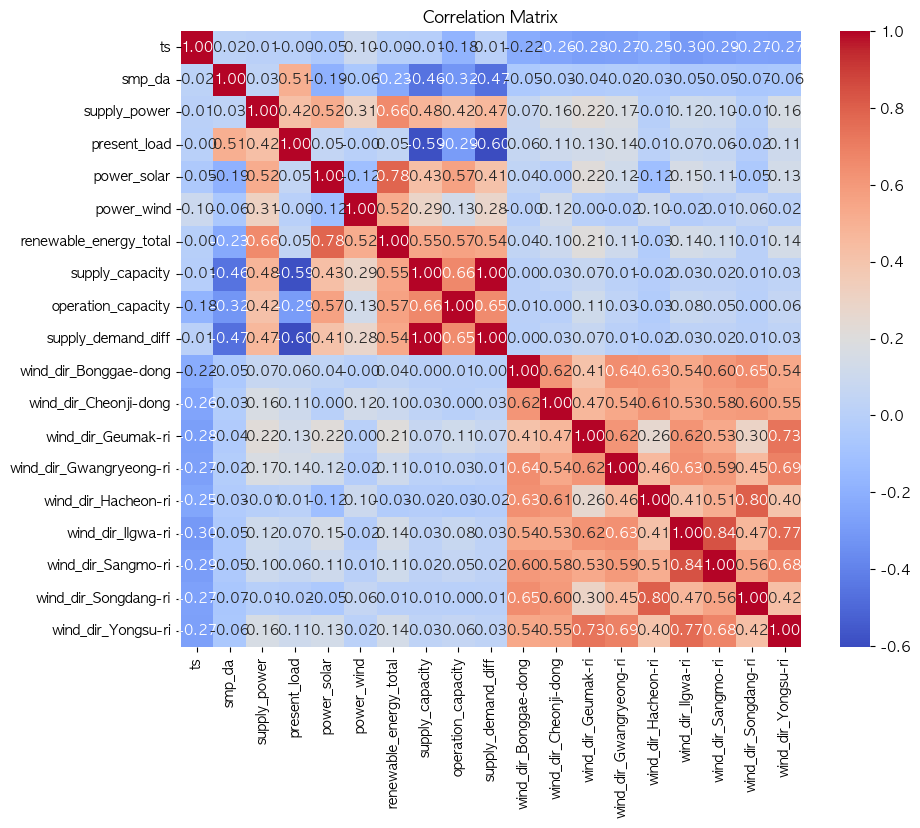

wind_spd


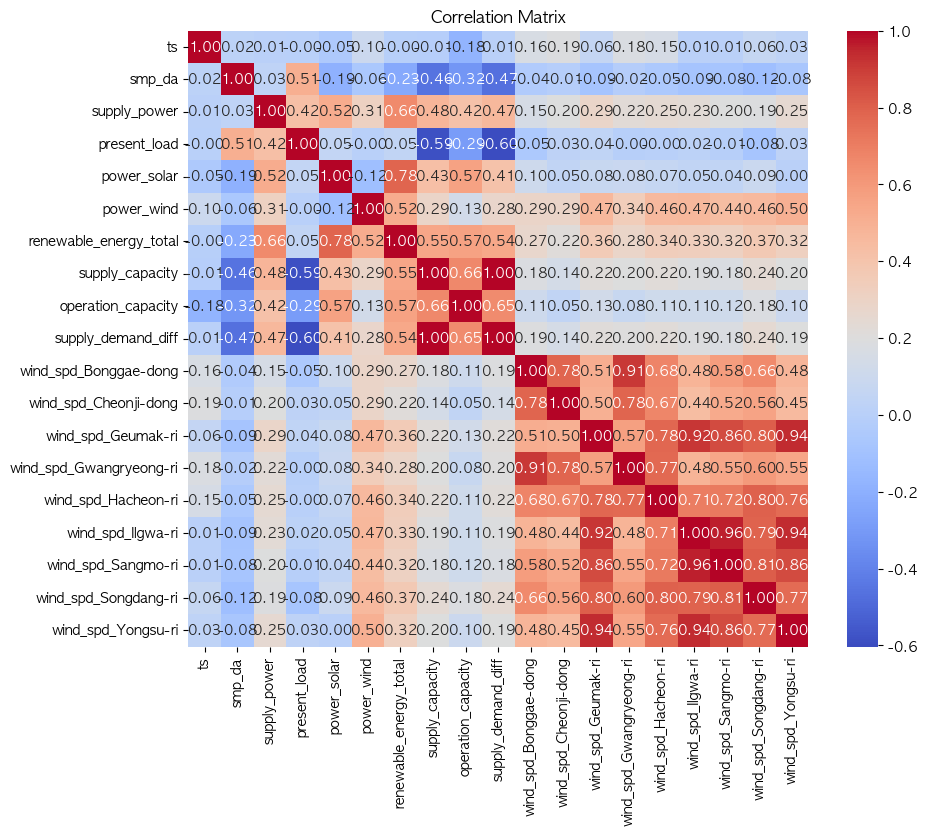

wind_gust_spd


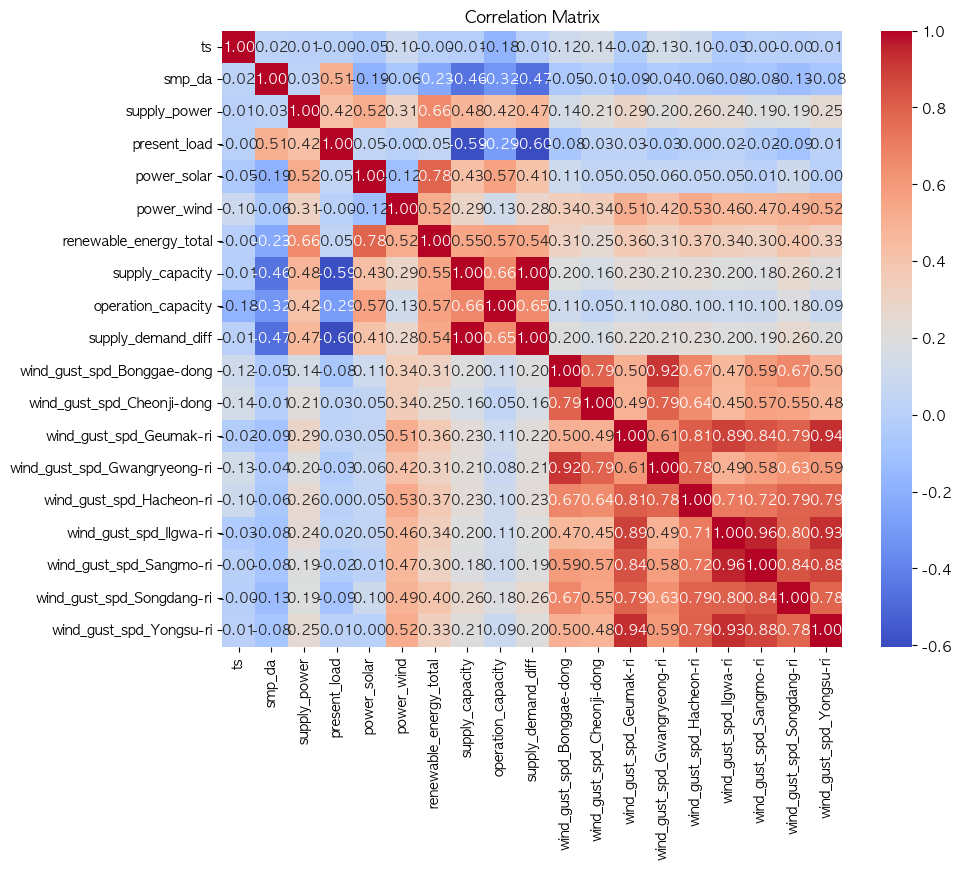

rel_hum


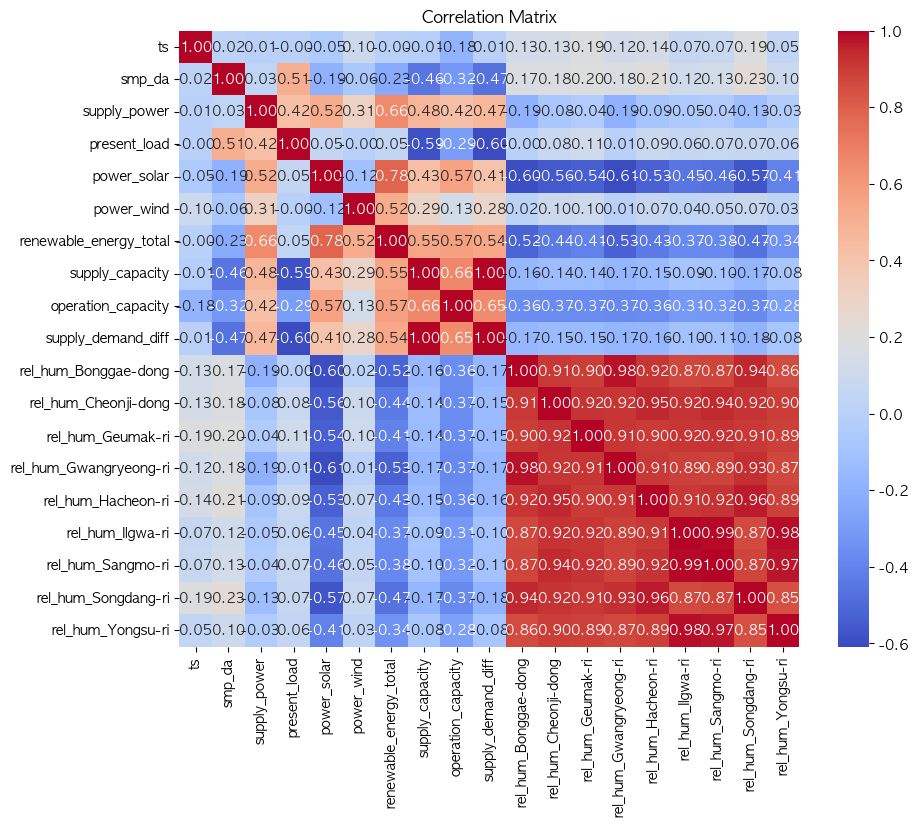

vis


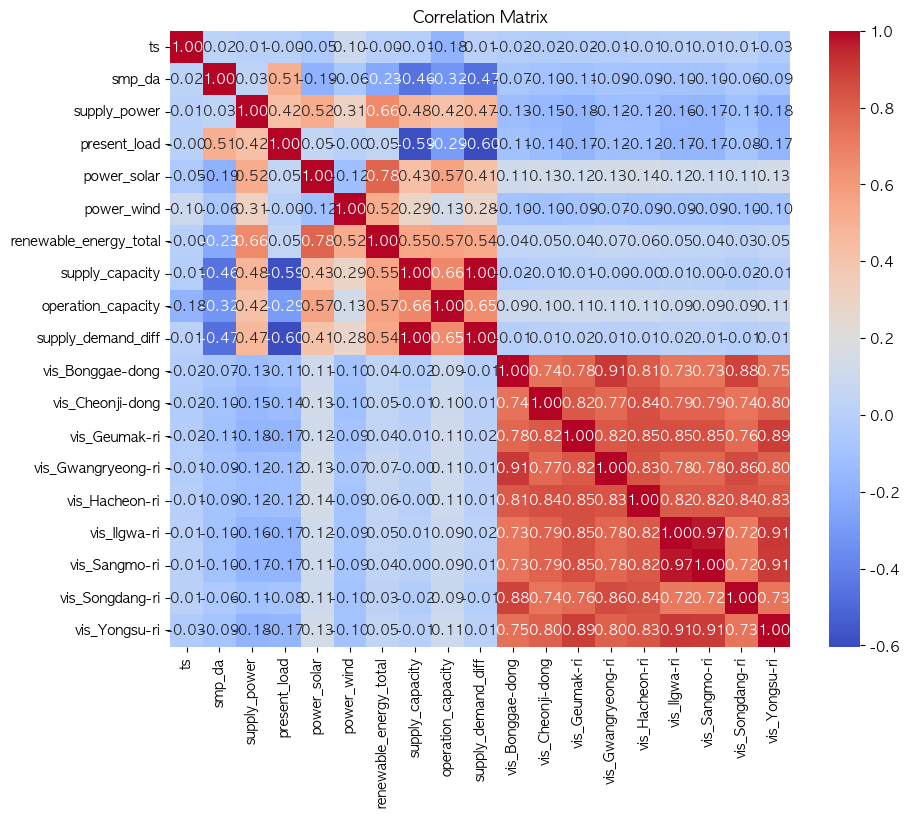

ceiling


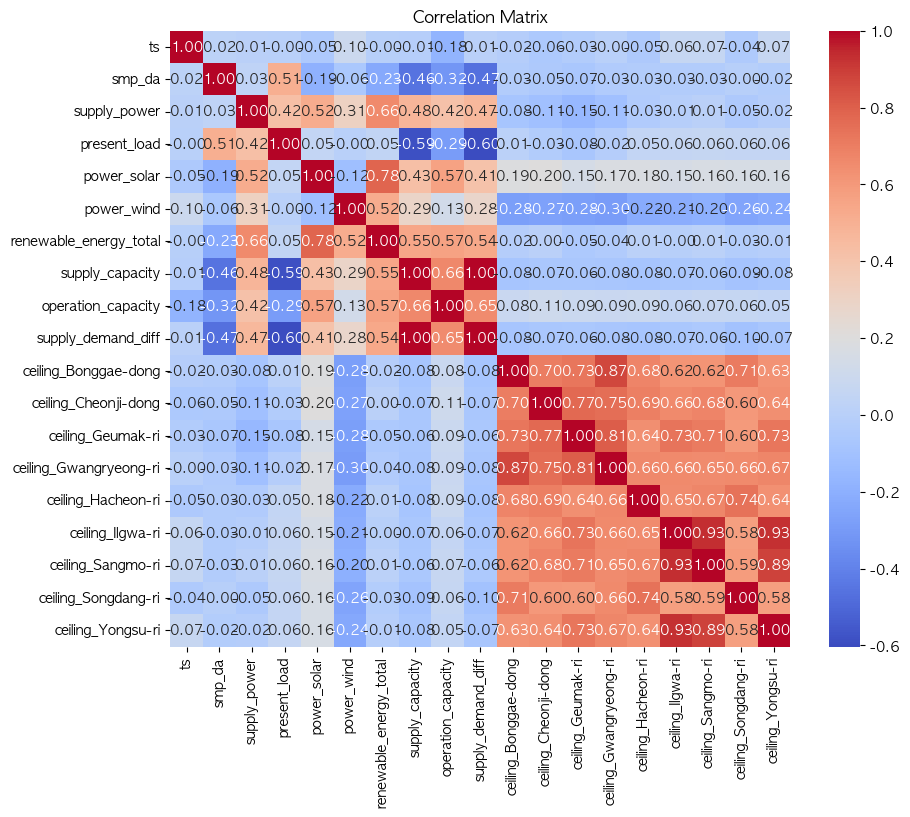

uv_idx


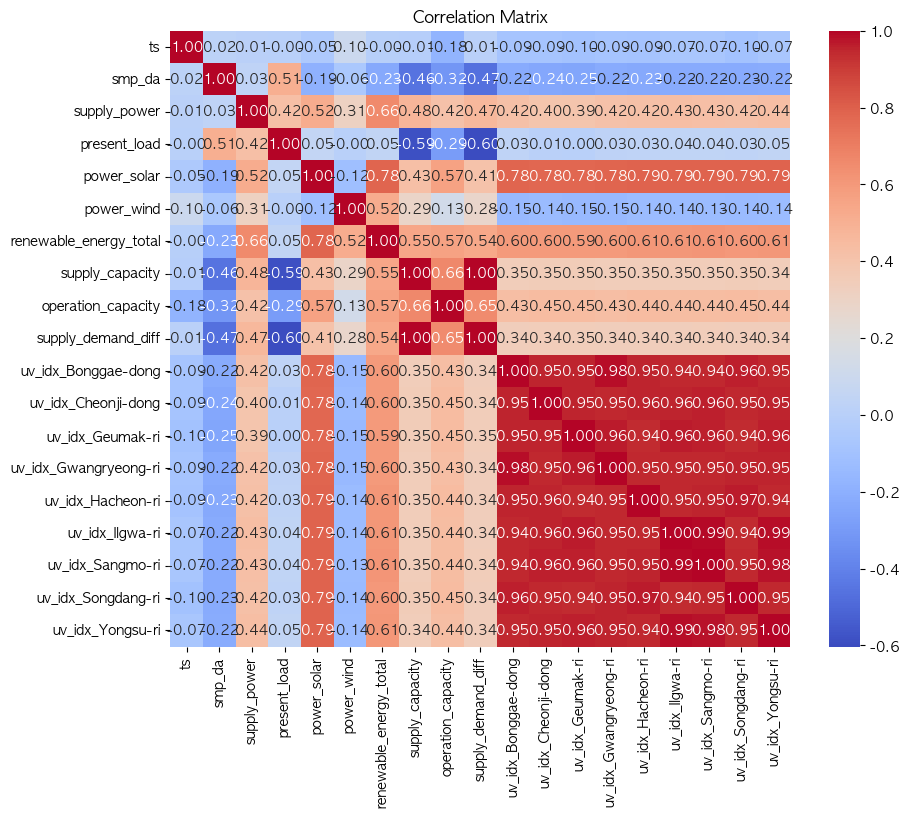

precip_prob


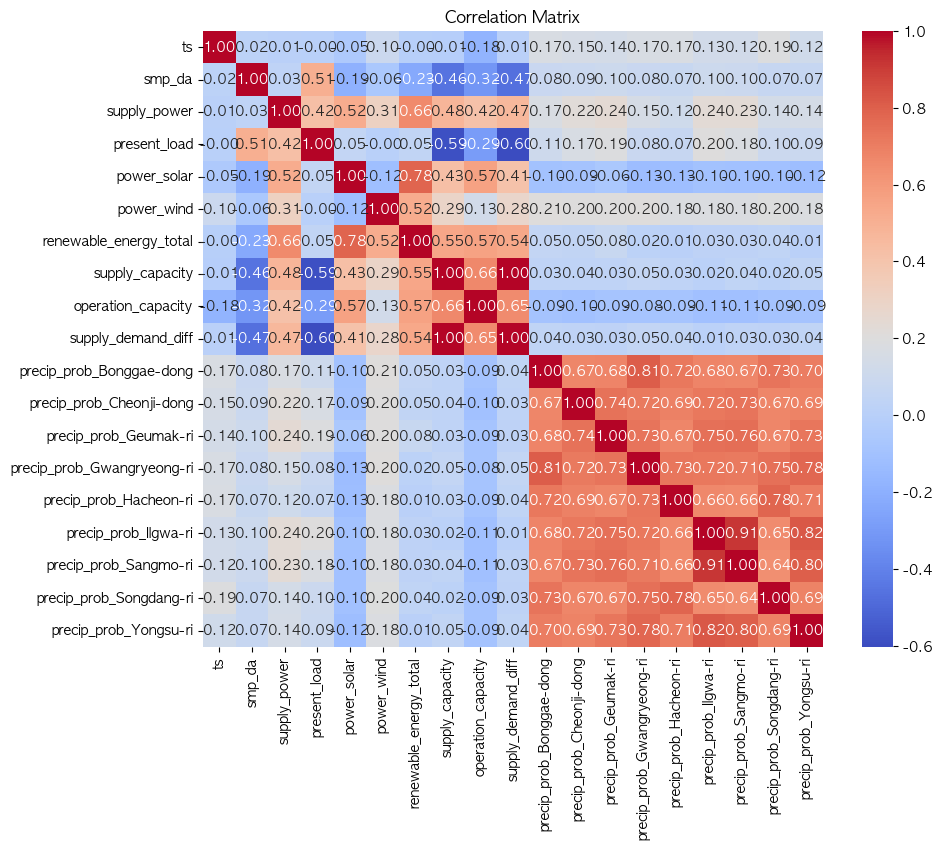

rain_prob


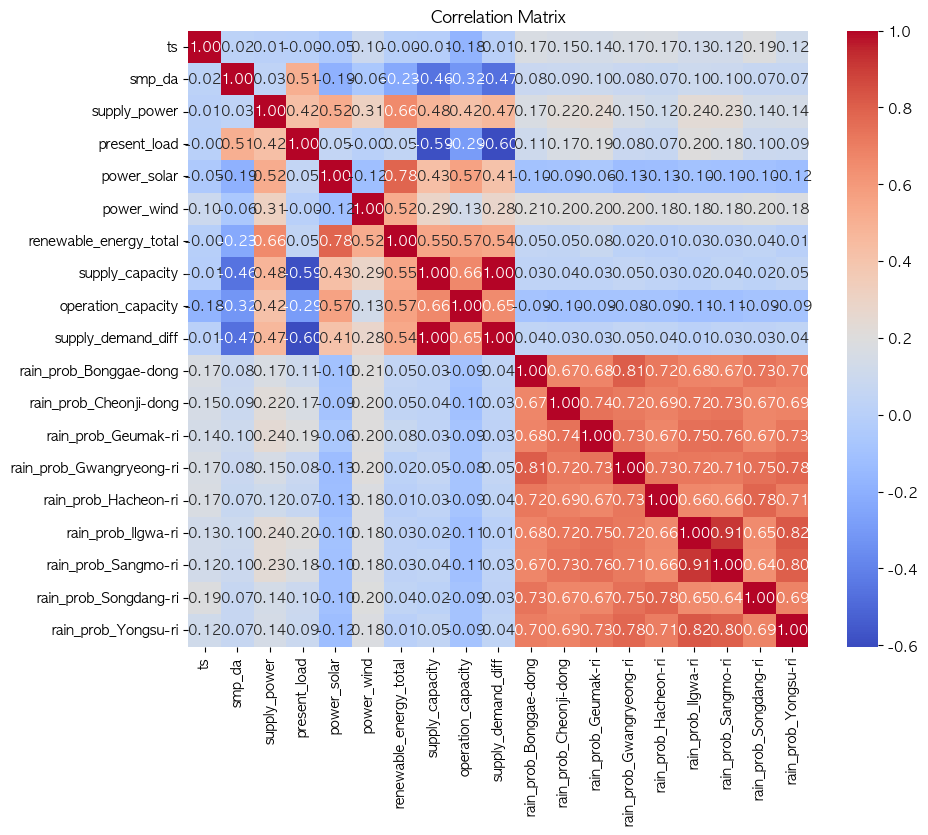

snow_prob


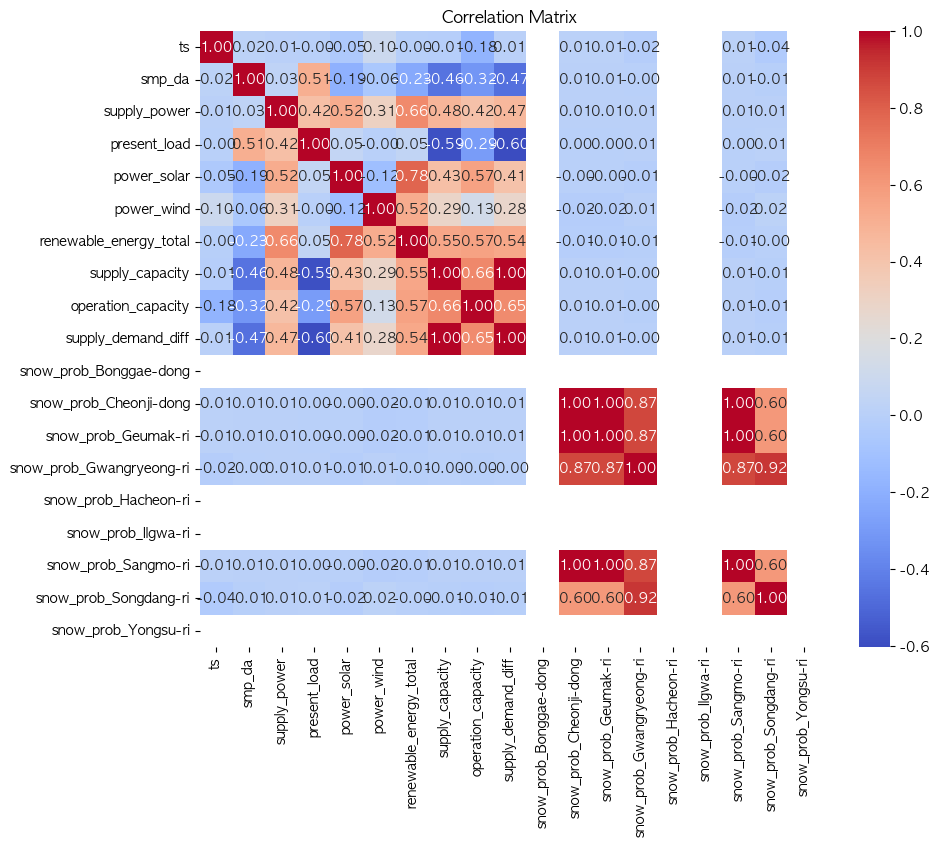

ice_prob


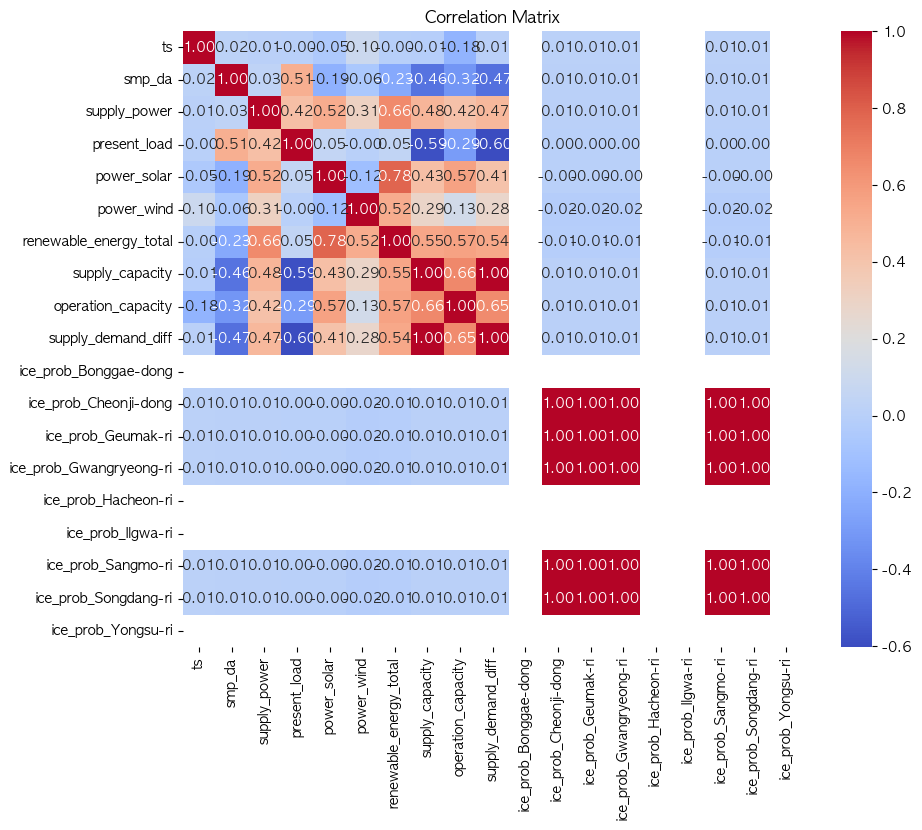

total_liq


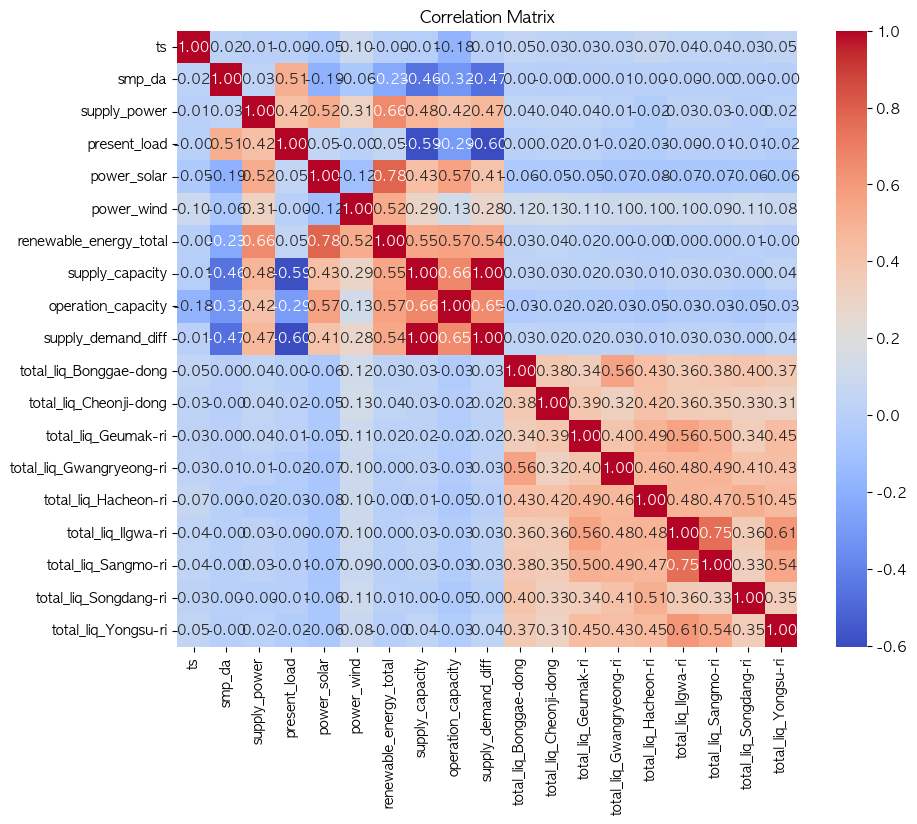

rain


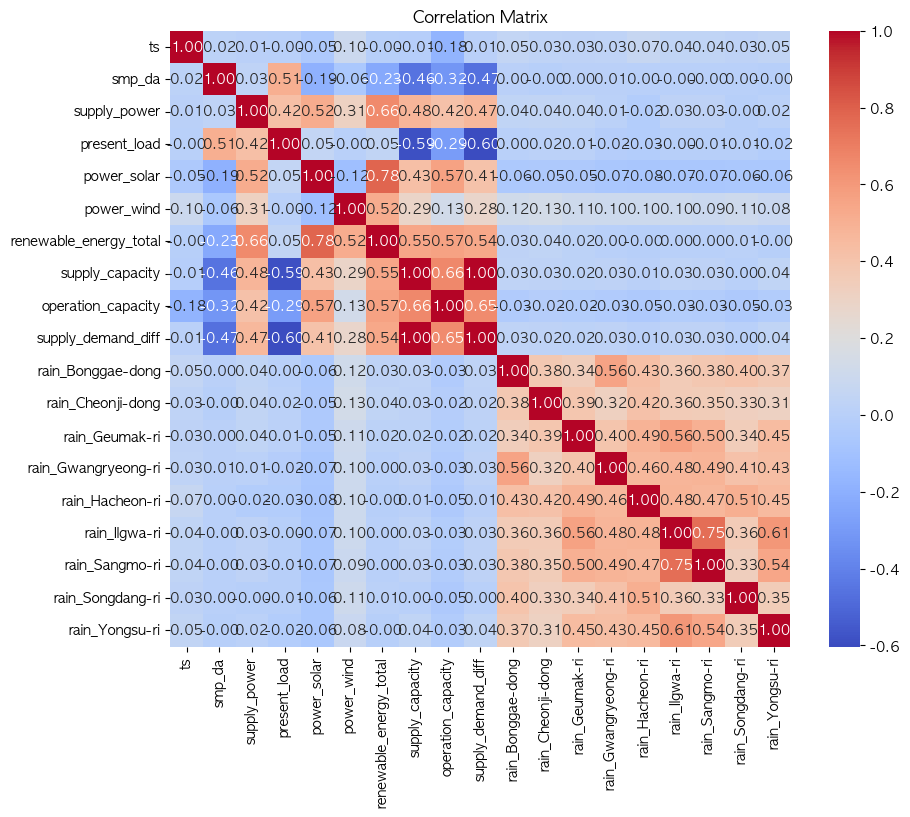

snow


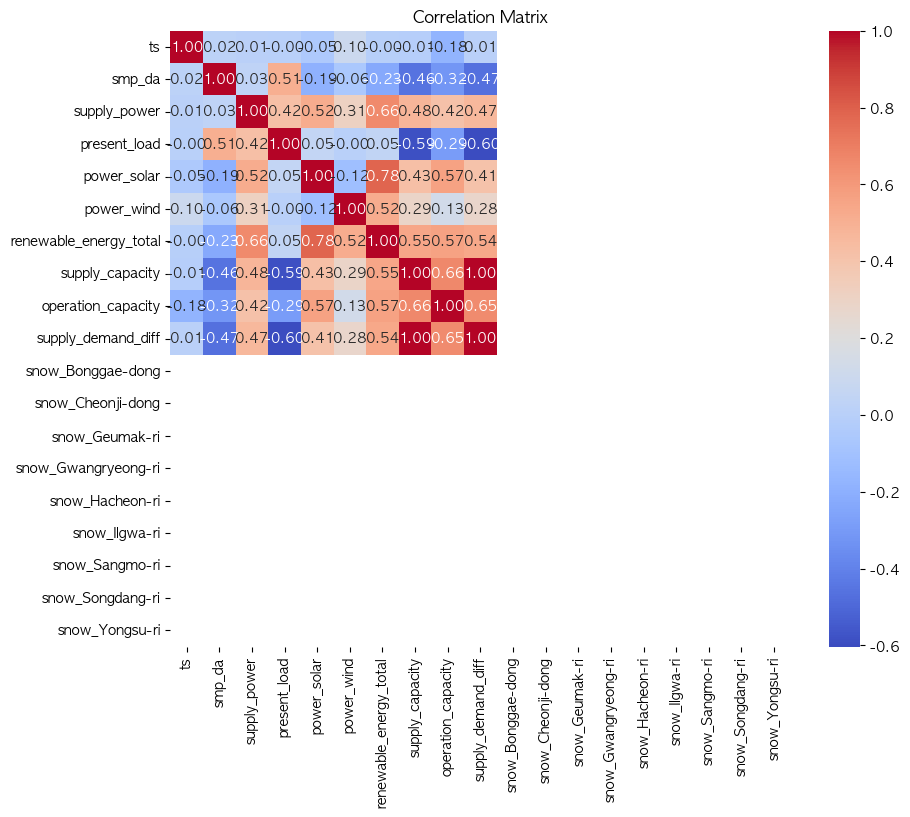

ice


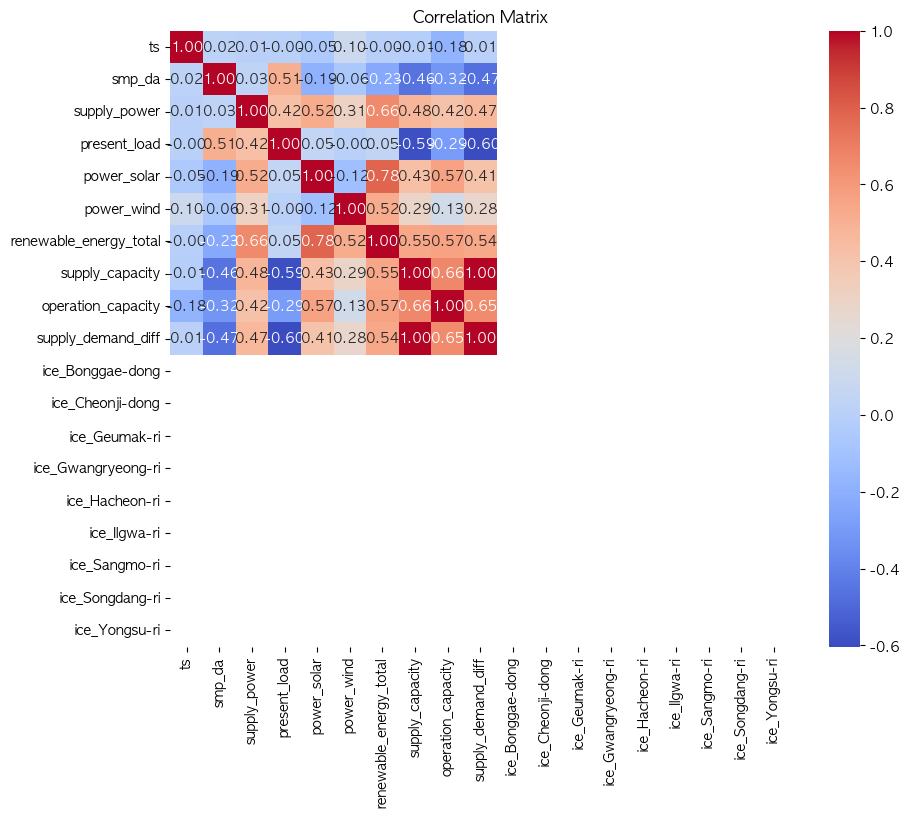

cld_cvr


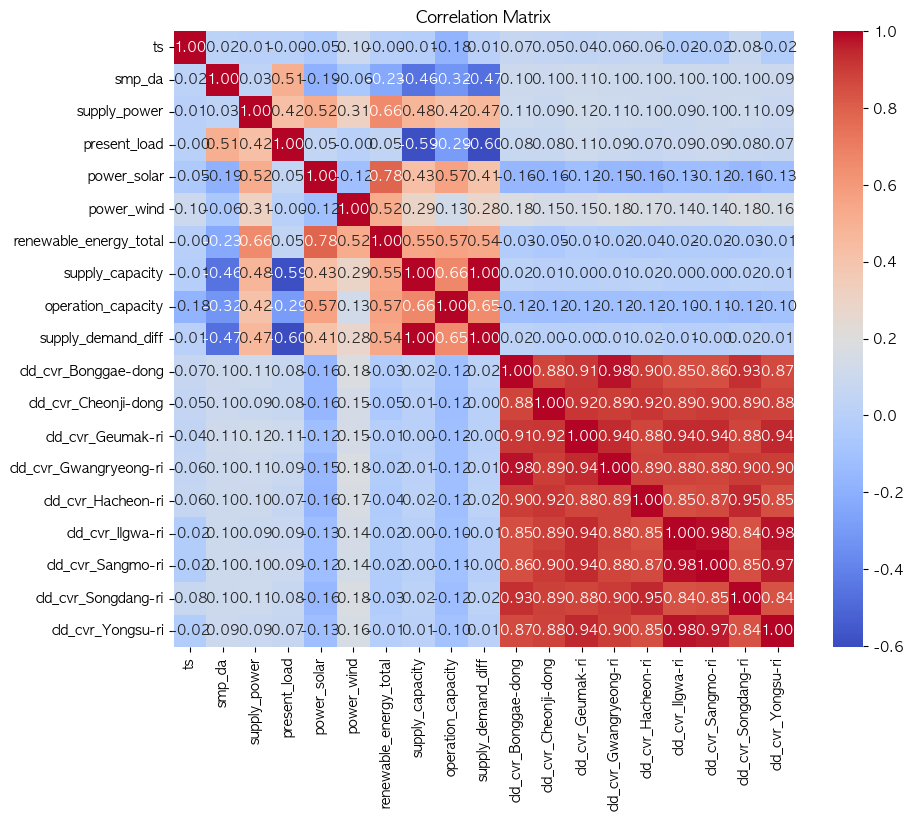

In [17]:
weather_fdata1.drop(columns=['base_ts'], inplace=True)

# duplicates = weather_fdata1[weather_fdata1.duplicated(subset=['ts', 'location'], keep=False)]
# print(duplicates)

columns = weather_fdata1.columns.drop(['location', 'ts'])
print(columns)

for column in columns:
    print(column)
    df_pivoted = weather_fdata1.pivot_table(index='ts', columns='location', values=column, aggfunc='mean').add_prefix(column+'_')
    pivot_merged_data = merged_data.merge(df_pivoted, on='ts', how='left')
    correlation_matrix = pivot_merged_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [18]:
# Correlation of fdata1 & supply data

# temp, real_temp, wet_bulb_temp : supply_power, present_load
# wind_spd, wind_gust_spd        : power_wind
# real_hum                       : power_solar, renewable_energy_total
# uv_idx                         : supply_power, power_solar, renewable_energy_total, operation_capacity

Index(['cloud', 'temp', 'temp_max', 'temp_min', 'humidity', 'ground_press',
       'wind_speed', 'wind_dir', 'rain', 'snow'],
      dtype='object')
cloud


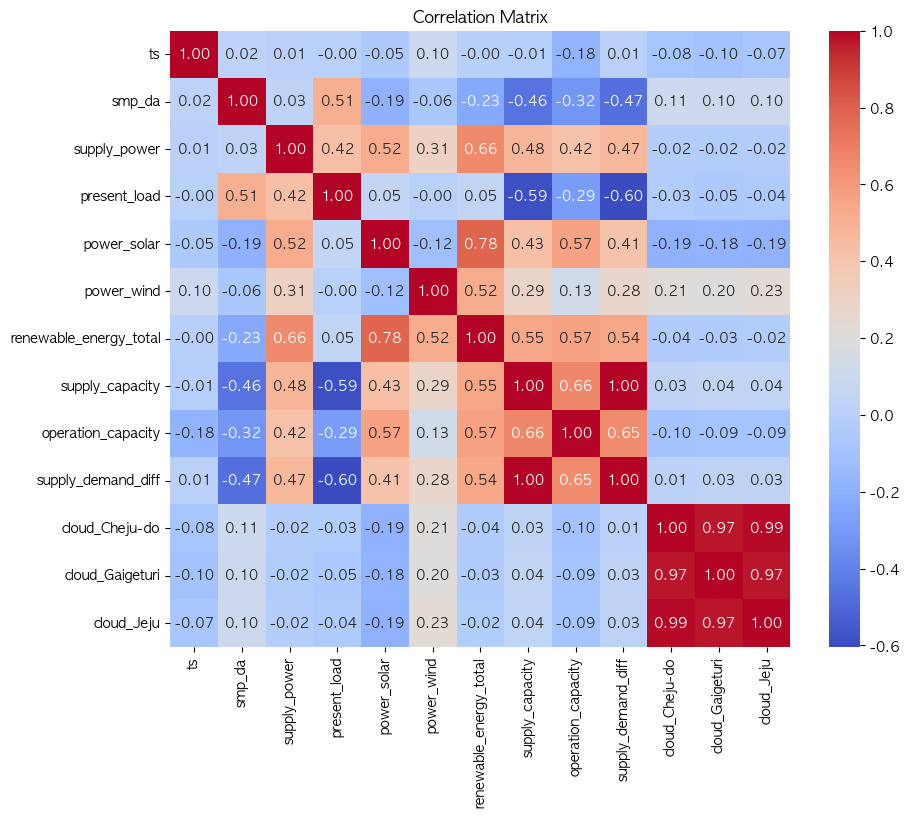

temp


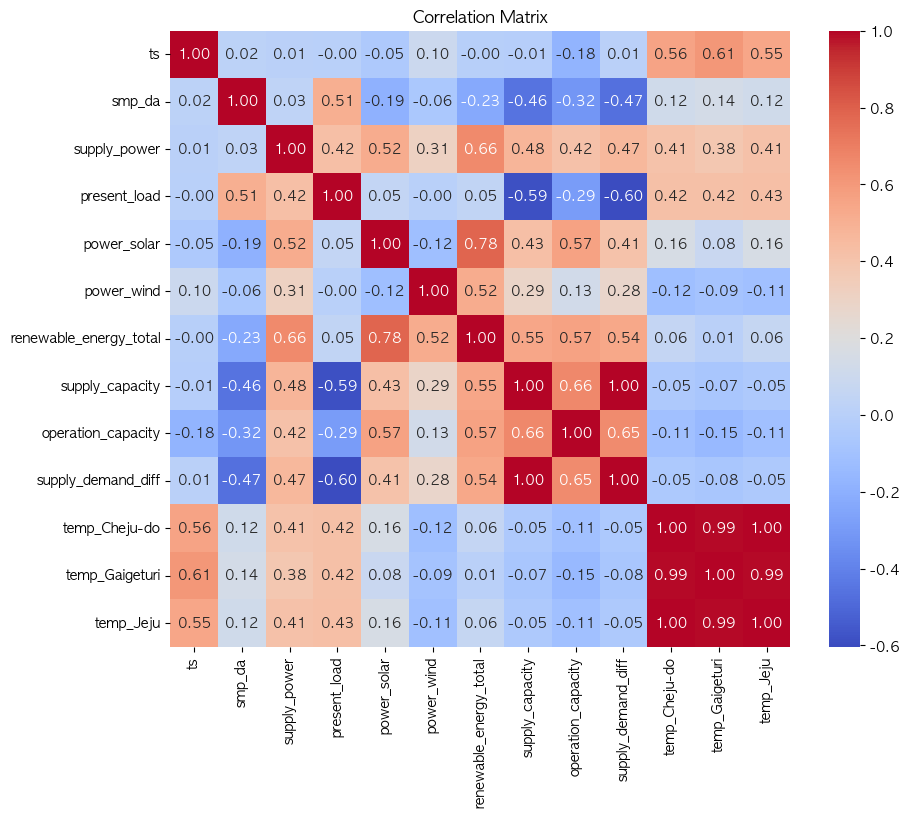

temp_max


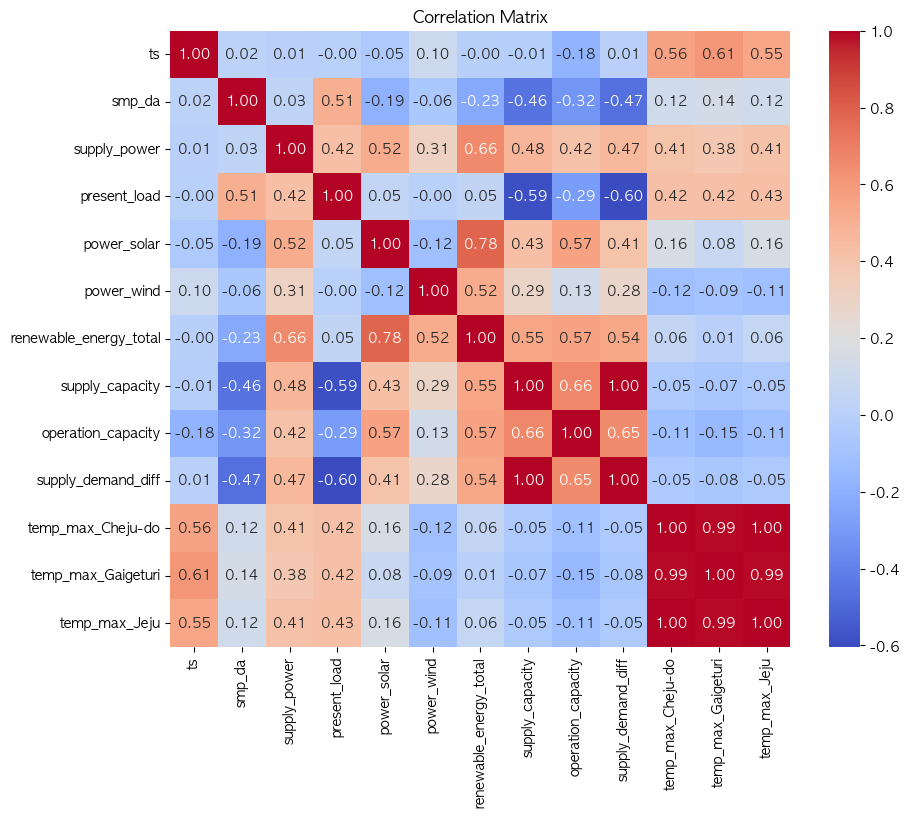

temp_min


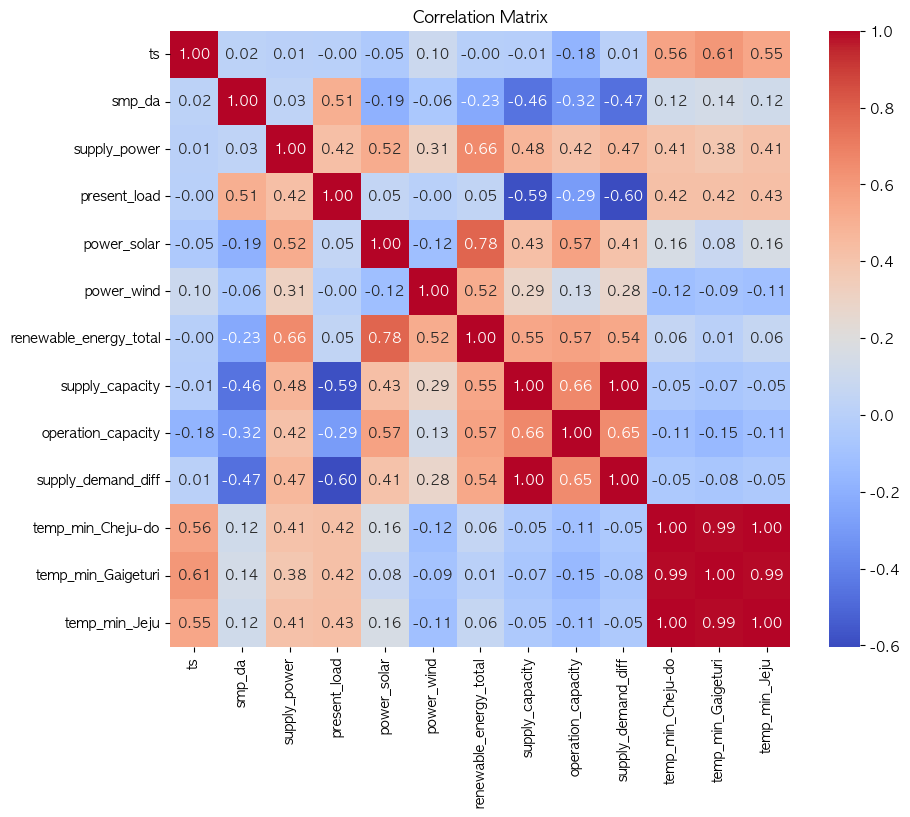

humidity


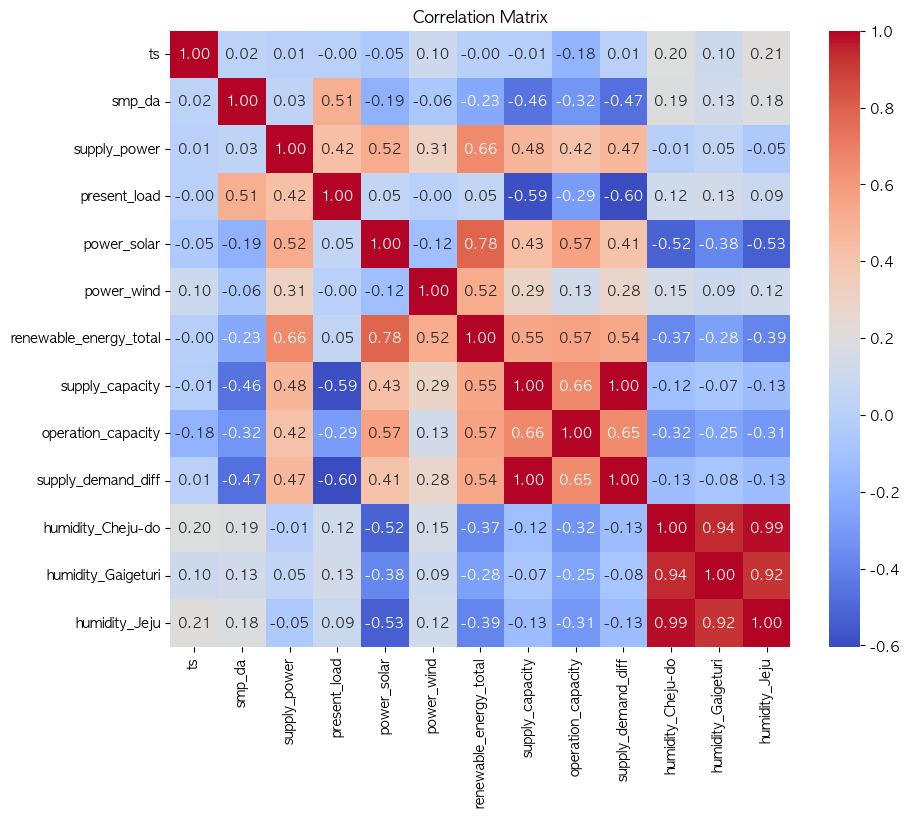

ground_press


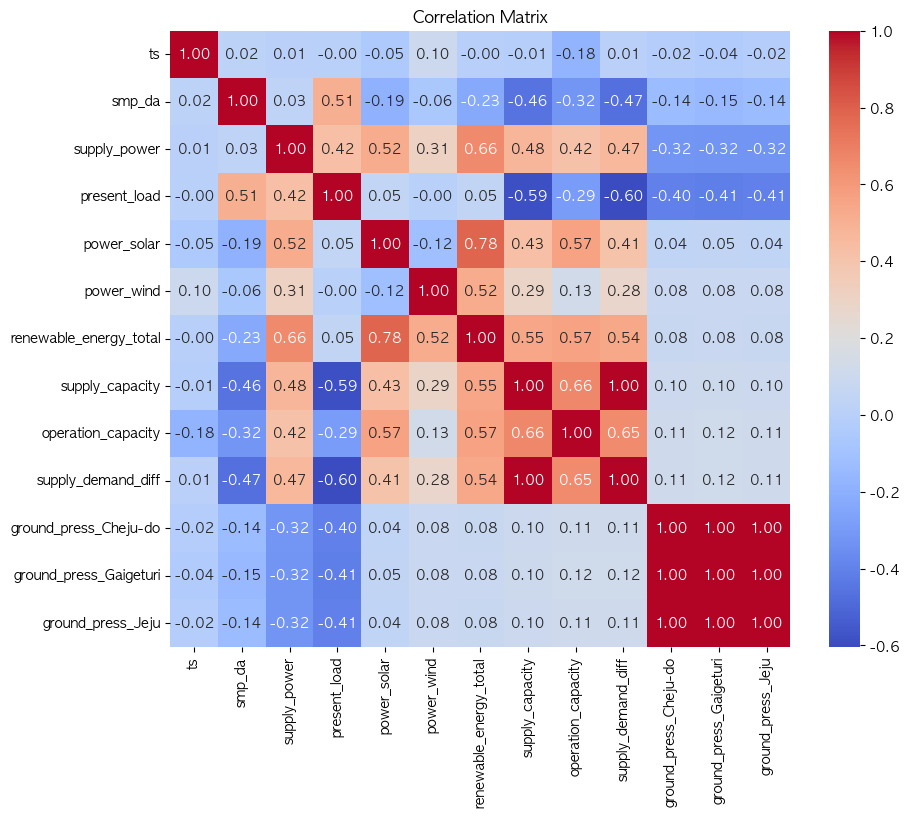

wind_speed


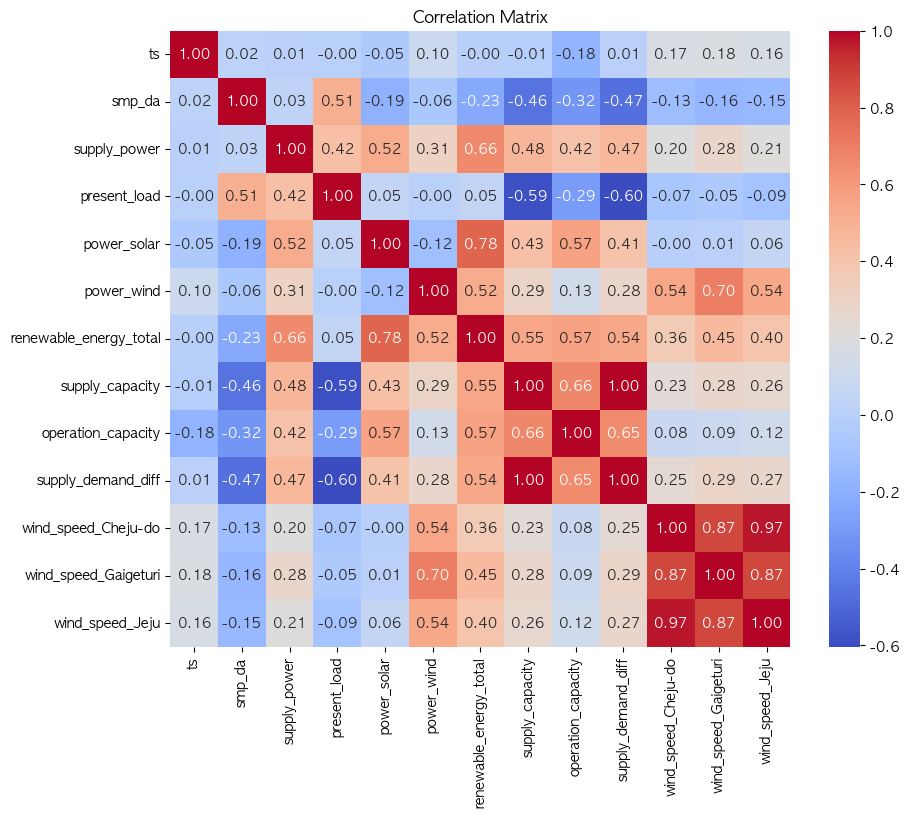

wind_dir


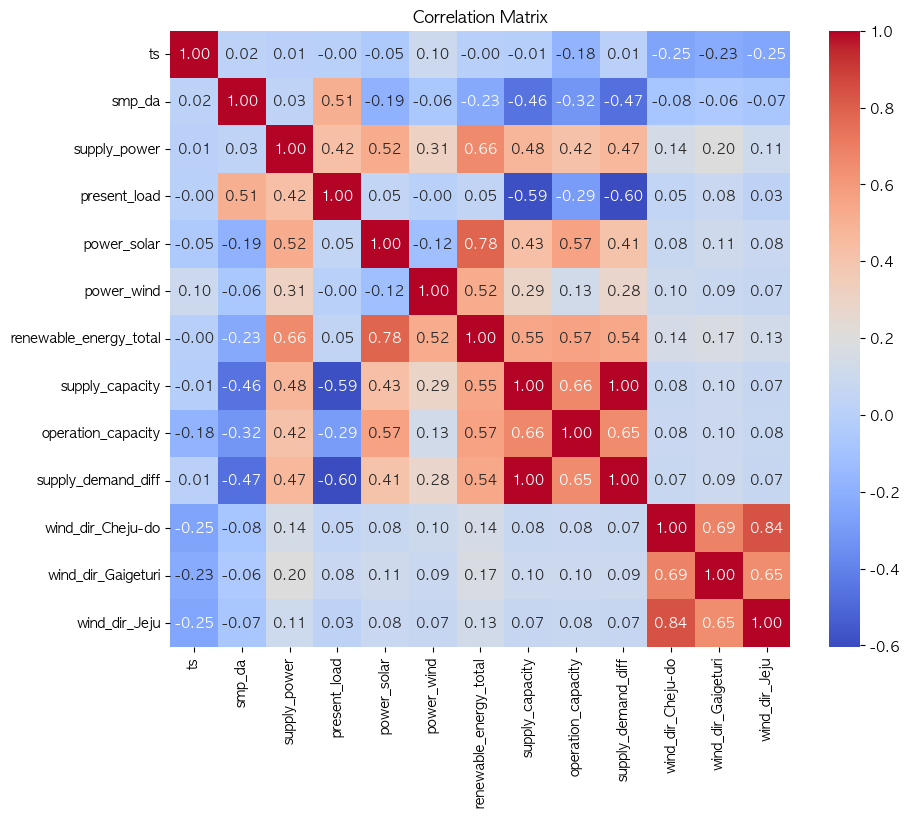

rain


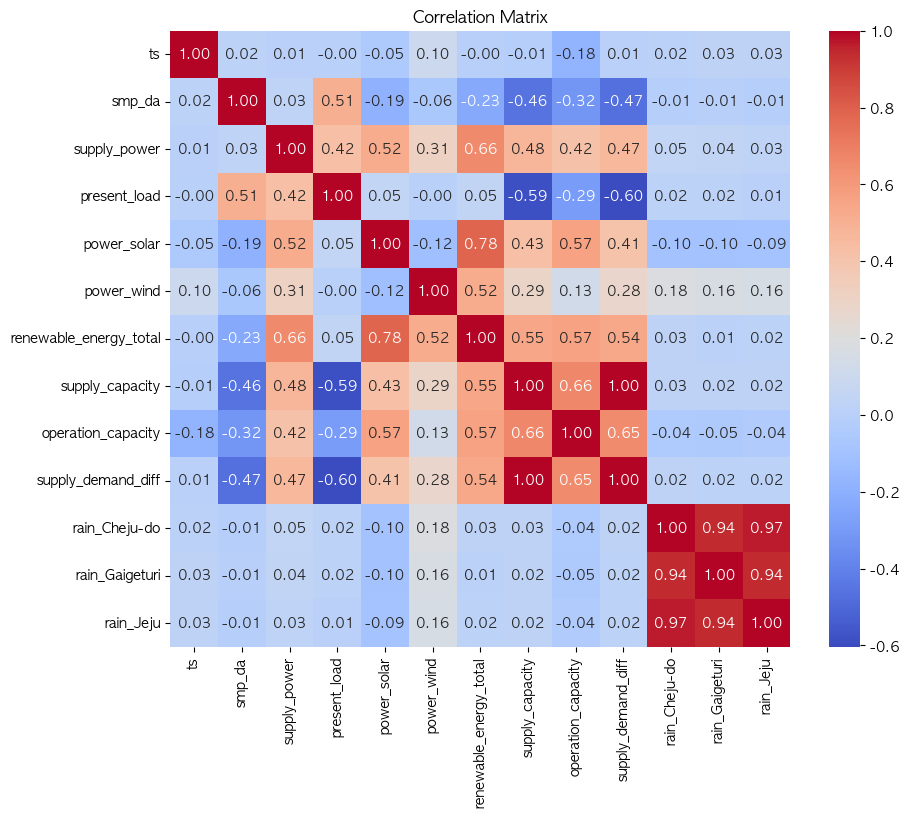

snow


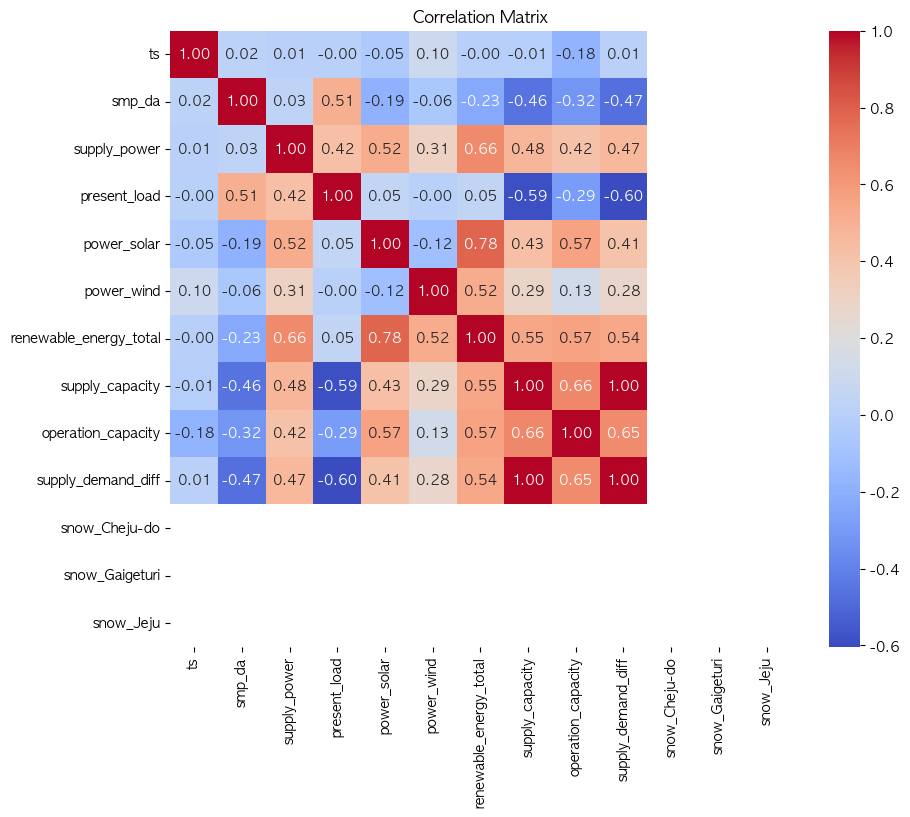

In [21]:
weather_fdata2.drop(columns=['base_ts'], inplace=True)

# duplicates = df[df.duplicated(subset=['ts', 'location'], keep=False)]
# print(duplicates)

columns = weather_fdata2.columns.drop(['location', 'ts'])
print(columns)

for column in columns:
    print(column)
    df_pivoted = weather_fdata2.pivot_table(index='ts', columns='location', values=column).add_prefix(column+'_')
    pivot_merged_data = merged_data.merge(df_pivoted, on='ts', how='left')
    correlation_matrix = pivot_merged_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [23]:
# Correlation of fdata2 & supply data

# temp, temp_max, temp_min : supply_power, present_load
# humidity                 : power_solar
# ground_press             : supply_power (0.3), present_load (0.4)
# wind_speed               : power_wind, renewable_energy_total